In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import math

%matplotlib inline

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [ ]:
from google.colab import files
import io
uploaded = files.upload()
df_upload = pd.read_csv(io.BytesIO(uploaded['db_in_out_2.csv']))
df = df_upload
# print(df)

Saving db_in_out_2.csv to db_in_out_2 (1).csv


In [ ]:
df.columns

Index(['Date', 'weekdays', 'is_holiday', 'holiday_name', 'holiday_type',
       'holiday_sequence', 'RH_in_7', 'RH_in_15', 'RH_in_30', 'next_RH',
       'INFLOW', 'OUTFLOW'],
      dtype='object')

In [ ]:
yval = df['INFLOW'].to_numpy()[round(len(df)*0.8):]

In [ ]:
df['dayofmonth'] = 0
for i in range(len(df)):
    df.loc[i, 'dayofmonth'] = int(df.loc[i, 'Date'][-2:])

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    """Helper function to plot our time series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

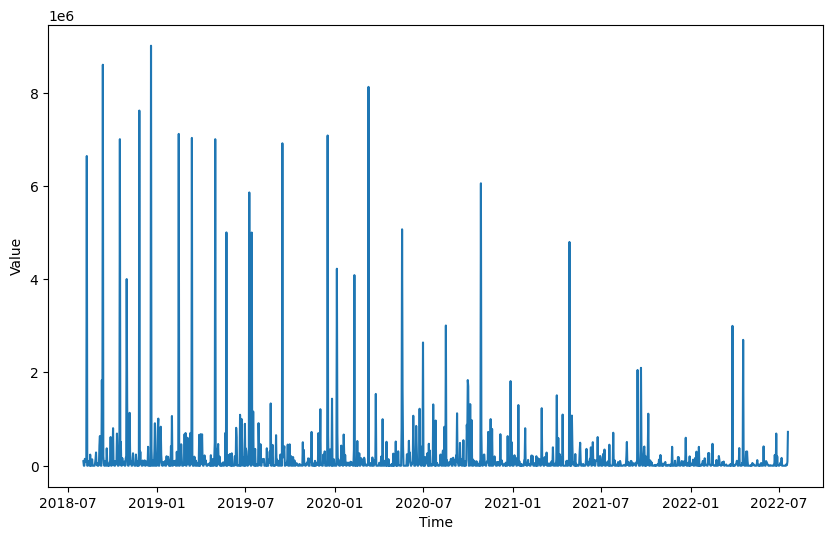

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(df.index, df.INFLOW)
plt.show()

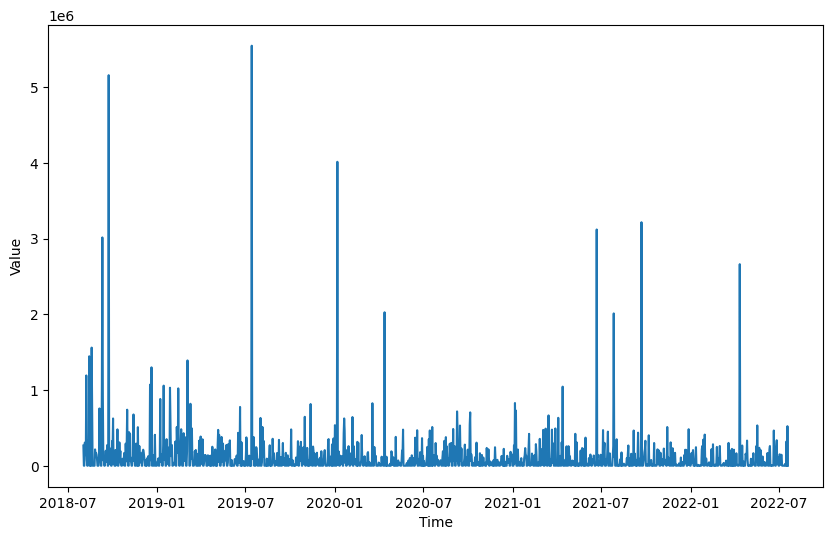

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(df.index, df.OUTFLOW)
plt.show()

In [ ]:
cols = ['weekdays', 'is_holiday', 'holiday_type', 'holiday_sequence', 'OUTFLOW', 'INFLOW', 'dayofmonth', 'next_RH', 'RH_in_7']

df = df[cols]

categorical_columns = ['weekdays', 'holiday_type', 'holiday_sequence']
df = pd.get_dummies(df, columns=categorical_columns)

In [ ]:
def create_features(df):
    "Create time series"
    df = df.copy()
    # df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    return df

In [ ]:
df = create_features(df)
df.columns

Index(['is_holiday', 'OUTFLOW', 'INFLOW', 'dayofmonth', 'next_RH', 'RH_in_7',
       'weekdays_Friday', 'weekdays_Monday', 'weekdays_Saturday',
       'weekdays_Sunday', 'weekdays_Thursday', 'weekdays_Tuesday',
       'weekdays_Wednesday', 'holiday_type_NH', 'holiday_type_RH',
       'holiday_type_WK', 'holiday_sequence_HHH', 'holiday_sequence_HHW',
       'holiday_sequence_HWH', 'holiday_sequence_HWW', 'holiday_sequence_WHH',
       'holiday_sequence_WHW', 'holiday_sequence_WWH', 'holiday_sequence_WWW',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear'],
      dtype='object')

In [ ]:
def customLog(val):
    if math.isinf(-1*np.log10(val)):
        return -10
    return np.log10(val)

In [ ]:
df["OUTFLOW_LOG"] = df.OUTFLOW.apply(customLog)

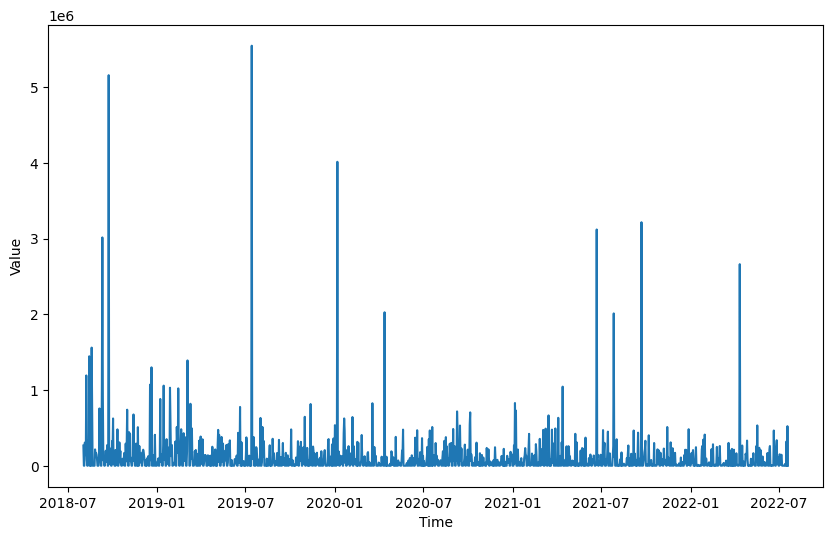

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(df.index, df.OUTFLOW)
plt.show()

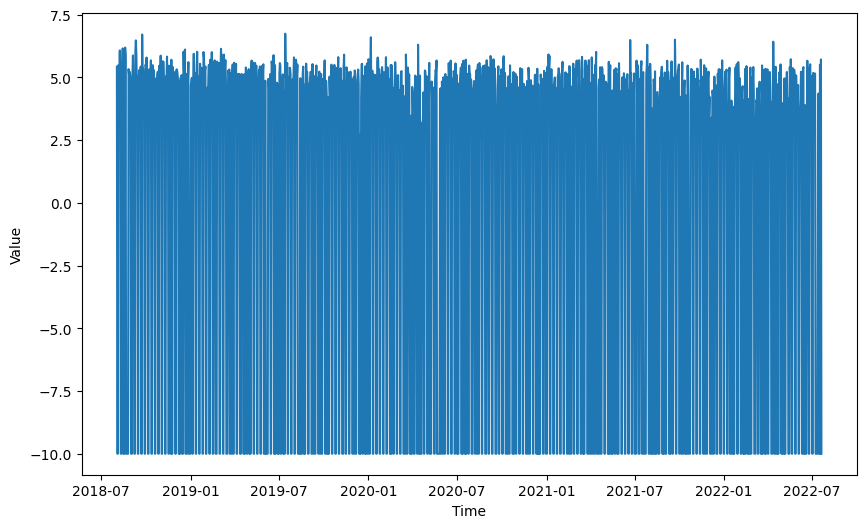

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(df.index, df.OUTFLOW_LOG)
plt.show()

In [ ]:
FEATURES = ['is_holiday', 'dayofmonth', 'next_RH', 'RH_in_7',
       'weekdays_Friday', 'weekdays_Monday', 'weekdays_Saturday',
       'weekdays_Sunday', 'weekdays_Thursday', 'weekdays_Tuesday',
       'weekdays_Wednesday', 'holiday_type_NH', 'holiday_type_RH',
       'holiday_type_WK', 'holiday_sequence_HHH', 'holiday_sequence_HHW',
       'holiday_sequence_HWH', 'holiday_sequence_HWW', 'holiday_sequence_WHH',
       'holiday_sequence_WHW', 'holiday_sequence_WWH', 'holiday_sequence_WWW',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET='OUTFLOW_LOG'

x = df[FEATURES]
y = df['OUTFLOW_LOG']

xtrain, ytrain = x[:round(0.8*len(x))], y[:round(0.8*len(y))]
xtest, ytest = x[round(0.8*len(x)):], y[round(0.8*len(y)):]

In [ ]:
model_xgb=xgb.XGBRegressor()
model_xgb.fit(xtrain,ytrain)
pred=model_xgb.predict(xtest)

In [ ]:
def showDiffPlot(ytest, pred, title, x=None, y=None):
    sx = 30 if x==None else x
    sy = 15 if y==None else y
    plt.figure(figsize=(sx, sy))
    plt.plot(ytest, label="validation set")
    plt.plot(pred, label="predicted")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.show()

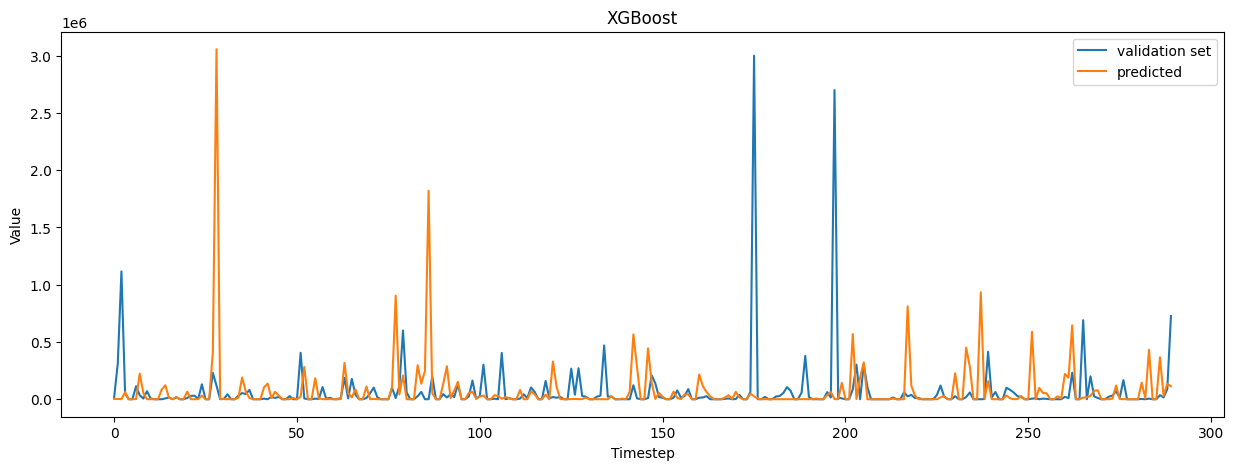

In [ ]:
for i in range(len(pred)):
    if pred[i]<=-10:
        pred[i]=0
    else : pred[i] = 10**pred[i]

showDiffPlot(yval, pred, 'XGBoost',15,5)

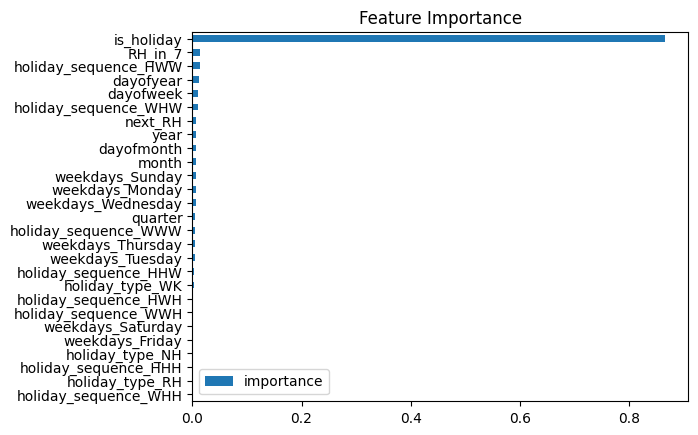

In [ ]:
fi = pd.DataFrame(data= model_xgb.feature_importances_,
             index=model_xgb.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
FEATURES = ['is_holiday', 'dayofmonth', 'next_RH', 'RH_in_7',
       'weekdays_Monday', 'weekdays_Wednesday',
       'weekdays_Sunday', 'weekdays_Thursday', 'weekdays_Tuesday',
       'holiday_type_WK', 'holiday_sequence_HHW', 'holiday_sequence_HWW',
       'holiday_sequence_WHW', 'holiday_sequence_WWW',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET='OUTFLOW_LOG'

x = df[FEATURES]
y = df['OUTFLOW_LOG']

xtrain, ytrain = x[:round(0.8*len(x))], y[:round(0.8*len(y))]
xtest, ytest = x[round(0.8*len(x)):], y[round(0.8*len(y)):]

In [ ]:

model_xgb=xgb.XGBRegressor()
model_xgb.fit(xtrain,ytrain)
pred=model_xgb.predict(xtest)

In [ ]:
def showDiffPlot(ytest, pred, title, x=None, y=None):
    sx = 30 if x==None else x
    sy = 15 if y==None else y
    plt.figure(figsize=(sx, sy))
    plt.plot(ytest, label="validation set")
    plt.plot(pred, label="predicted")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.show()

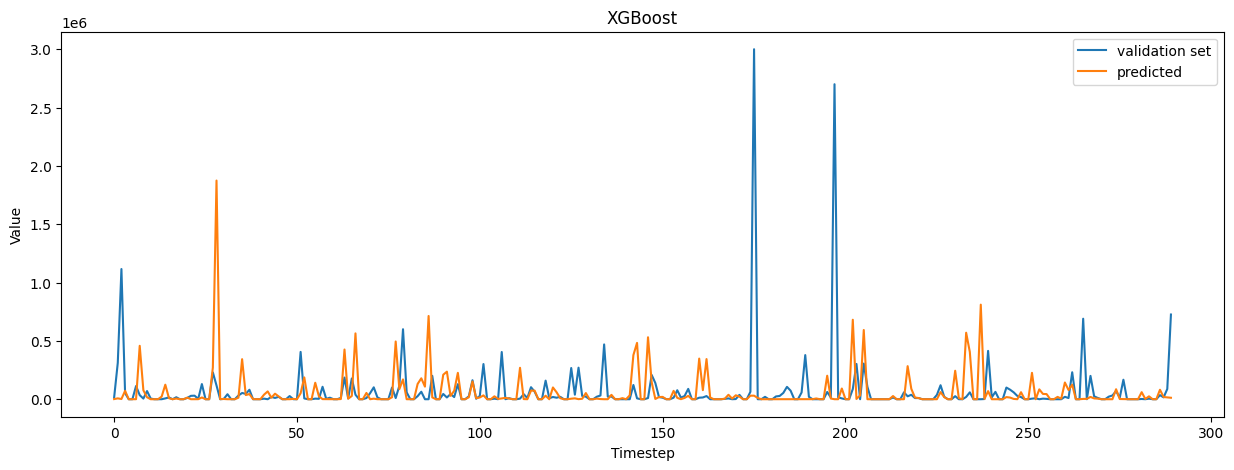

In [ ]:

for i in range(len(pred)):
    if pred[i]<=-10:
        pred[i]=0
    else : pred[i] = 10**pred[i]

showDiffPlot(yval, pred, 'XGBoost',15,5)